# 1. 读取配置文件

In [25]:
import json

In [26]:
config_path = "../exps/momentum.json"
with open(config_path, 'r') as f:
    args = json.load(f)
print(args)

{'prefix': 'e250+50', 'dataset': 'cifar100', 'memory_size': 0, 'shuffle': True, 'init_cls': 50, 'increment': 10, 'model_name': 'momentum', 'convnet_type': 'resnet18', 'initial_model_path': None, 'device': ['0'], 'seed': [1993], 'init_epochs': 250, 'init_lr': 0.1, 'init_weight_decay': 0.0005, 'epochs': 50, 'lr': 0.05, 'weight_decay': 0.0005, 'batch_size': 128, 'num_workers': 8, 'pin_memory': True, 'T': 2, 'pre_norm': True, 'momentum': 0.99, 'generator': 'noise'}


In [27]:
import torch

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 2. 读取数据集

In [29]:
import torchvision as tv
from torch.utils.data import DataLoader

In [30]:
trsf = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
])
dataset = tv.datasets.CIFAR100(root='../data/CIFAR', train=False, transform=trsf, download=False)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=0)

In [31]:
len(dataset)

10000

# 2.1 tools

In [32]:
import numpy as np

In [33]:
def layernorm(_x, _eps=1e-05):
    """
    :param _x: ndarray of [n, dim]
    """
    _mean = np.mean(_x, axis=1, keepdims=True)
    _std = np.std(_x, axis=1, keepdims=True)
    _x = (_x - _mean) / (_std + _eps)
    return _x

In [34]:
def extract_features(_extractor, _loader):
    _features = []
    _labels = []
    _extractor.to(device)
    _extractor.eval()
    for _i, (_x, _y) in tqdm(enumerate(_loader)):
        _x = _x.to(device)
        with torch.no_grad():
            _f = _extractor(_x)["features"]
        _features.append(_f.to("cpu"))
        _labels.append(_y)
    _features = torch.cat(_features, dim=0)
    _labels = torch.cat(_labels, dim=0)
    return _features, _labels

# 3. 读取模型

In [35]:
# 训练时不使用norm
# saved_path = "../saved/noLN_momentum_resnet18_cifar100_50_all.pkl"
# 训练时使用norm
saved_path = "../saved/e250+50_momentum_resnet18_cifar100_50_all.pkl"

In [36]:
import torch
from tqdm import tqdm
from utils.inc_net import HeadNet

In [37]:
model = HeadNet(args, False, None)

In [38]:
saved_all = torch.load(saved_path)
model.load_state_dict(saved_all["model_state_dict"], strict=False)
means = saved_all["means"]
stds = saved_all["stds"]

## 3.1 计算每个类的特征向量

In [39]:
features, labels = extract_features(model.convnet, dataloader)
features = features.numpy()
labels = labels.numpy()

40it [00:10,  3.73it/s]


In [40]:
print(features.shape, labels.shape)

(10000, 512) (10000,)


# 4. 对特征进行t-SNE可视化

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [42]:
def select_classes(_classes):
    _features = []
    _labels = []
    for _i, _l in enumerate(labels):
        if _l in _classes:
            _features.append(features[_i])
            _labels.append(_l)
    _features = np.array(_features)
    _labels = np.array(_labels)
    return _features, _labels

In [43]:
def show_tsne(_classes, _features, _labels, _colors):
    _tsne = TSNE(n_components=2, init='pca', random_state=0)
    _features = _tsne.fit_transform(_features)  # [n, 2]
    _class_features = [_features[_labels == i] for i in _classes]

    for i in range(len(_classes)):
        plt.scatter(_class_features[i][:, 0], _class_features[i][:, 1], c=_colors[i], label=_classes[i])
    plt.axis('off')
    plt.legend()
    plt.show()

## 4.1 旧类

In [46]:
selected_classes = [0, 15, 30, 45]
colors = ["#000000", "#BEBEBE", "#AE0000", "#8600FF"]
selected_features, selected_labels = select_classes(selected_classes)

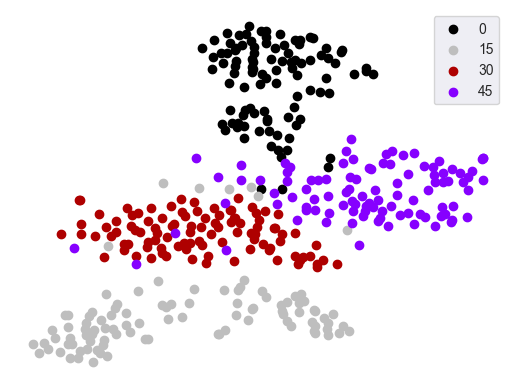

In [47]:
# 不使用norm
show_tsne(selected_classes, selected_features, selected_labels, colors)

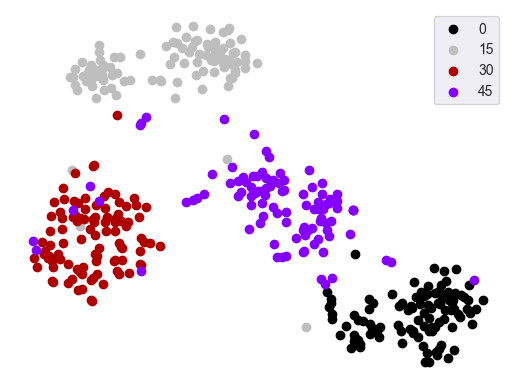

In [48]:
# 对特征向量使用norm
show_tsne(selected_classes, layernorm(selected_features), selected_labels, colors)

## 4.2 新类

In [49]:
selected_classes = [50, 65, 80, 95]
colors = ["#2828FF", "#00FFFF", "#00EC00", "#F9F900"]
selected_features, selected_labels = select_classes(selected_classes)

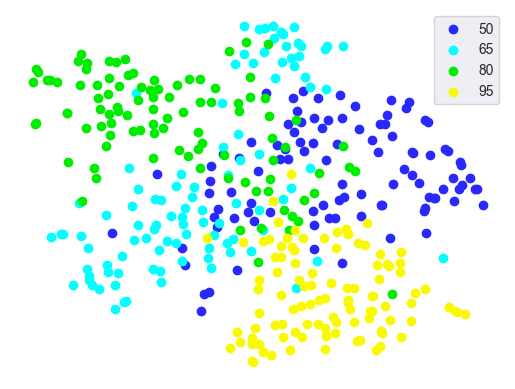

In [50]:
# 不使用norm
show_tsne(selected_classes, selected_features, selected_labels, colors)

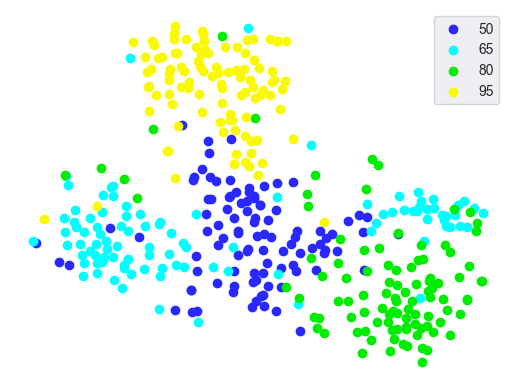

In [51]:
# 对特征向量使用norm
show_tsne(selected_classes, layernorm(selected_features), selected_labels, colors)